# Seq2Seq by TCN and DPAttention for forecast

1. 实现
2. 每个timeseries使用均值归一化(效果未提升）
3. Decoder使用Dense
4. Decoder使用Conv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch.nn.utils import weight_norm
from torchsummary import summary
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

In [3]:
def random_seed_set(seed):
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

## load data

In [4]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## normalization

In [5]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [6]:
def series_to_supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to RNN
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len, dim_1))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + target_len]
    print("supervised data: shape of x: {}, shape of y: {}".format(
        x.shape, y.shape))
    return x, y

## 5-folds TimeSeriesSplit

In [7]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## Seq2Seq model

### Encoder

In [8]:
class Chomp1d(nn.Module):
    """
    保证卷积输入输出维度一致
    """
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 kernel_size,
                 stride,
                 dilation,
                 padding,
                 dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(
            nn.Conv1d(n_inputs,
                      n_outputs,
                      kernel_size,
                      stride=stride,
                      padding=padding,
                      dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(
            nn.Conv1d(n_outputs,
                      n_outputs,
                      kernel_size,
                      stride=stride,
                      padding=padding,
                      dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1,
                                 self.dropout1, self.conv2, self.chomp2,
                                 self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs,
                                    1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class Encoder(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(Encoder, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2**i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [
                TemporalBlock(in_channels,
                              out_channels,
                              kernel_size,
                              stride=1,
                              dilation=dilation_size,
                              padding=(kernel_size - 1) * dilation_size,
                              dropout=dropout)
            ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x shape (batch_size, seq_len, input_size)
        # out shape (batch_size, seq_len, output_size)
        x = x.permute(0, 2, 1)
        out = self.network(x)
        out = out.permute(0, 2, 1)
        return out

### Additive Attention

In [9]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # `queries` 的形状：(`batch_size`，查询的个数，1，`num_hidden`)
        # `key` 的形状：(`batch_size`，1，“键－值”对的个数，`num_hiddens`)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # `self.w_v` 仅有一个输出，因此从形状中移除最后那个维度。
        # `scores` 的形状：(`batch_size`，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        # `values` 的形状：(`batch_size`，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

### DotProductAttentioin

In [10]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `queries` 的形状：(`batch_size`，查询的个数，`d`)
    # `keys` 的形状：(`batch_size`，“键－值”对的个数，`d`)
    # `values` 的形状：(`batch_size`，“键－值”对的个数，值的维度)
    # `valid_lens` 的形状: (`batch_size`，) 或者 (`batch_size`，查询的个数)
    def forward(self, queries, keys, values):
        d = queries.shape[-1]
        # 设置 `transpose_b=True` 为了交换 `keys` 的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)

### Decoder

In [11]:
class AttnDecoder(nn.Module):
    def __init__(self, input_size, hidden_dim, drop_prob):
        super(AttnDecoder, self).__init__()

        self.attention = DotProductAttention(drop_prob)
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim + input_size, hidden_dim), nn.ReLU(),
            nn.Dropout(drop_prob), nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), nn.Dropout(drop_prob))
        self.fc = nn.Sequential()

        input_size = hidden_dim
        i = 0
        while (input_size > 6):
            self.fc.add_module('linear{}'.format(i),
                               nn.Linear(input_size, round(input_size / 2)))
            self.fc.add_module('relu{}'.format(i), nn.ReLU())
            input_size = round(input_size / 2)
            i += 1
        self.fc.add_module('linear{}'.format(i), nn.Linear(input_size, 1))

    def forward(self, inputs, encoder_outputs):
        """
        :inputs shape (batch_size, target_len, input_size)
        :encoder_outputs shape (batch_size, seq_len, hidden_dim)
        """

        h = encoder_outputs[:, -1:, :]
        # h shape (batch_size, 1, hidden_dim)
        outputs = []

        for i in range(inputs.shape[1]):
            context = self.attention(h, encoder_outputs, encoder_outputs)
            # context shape (batch_size, 1, hidden_dim)
            if i:
                x = torch.cat((inputs[:, i:i + 1, :-1], out.detach()), dim=-1)
                # x shape (batch_size, 1, input_size)
            else:
                x = inputs[:, i:i + 1, :]
            dense_input = torch.cat((x, context), dim=-1)
            # dense_input shape (batch_size, 1, 2*hidden_dim + input_size-1)
            h = self.dense(dense_input)
            # h shape (batch_size, 1, hidden_dim)

            out = self.fc(h)
            # out shape (batch_size, 1, 1)
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1).squeeze(-1)
        # outputs shape (batch_size, tar_len)
        return outputs

### Seq2Seq_TCN

In [32]:
class Seq2Seq_TCN(nn.Module):
    def __init__(self, input_size, hidden_dim, drop_prob):
        super(Seq2Seq_TCN, self).__init__()
        self.encoder = Encoder(input_size, num_channels=[24, 32, 40, 48, 56, 64], dropout=drop_prob)
        self.decoder = AttnDecoder(input_size, hidden_dim, drop_prob)
    
    def forward(self, encoder_inputs, decoder_inputs):
        # encoder_inputs shape (batch_size, seq_len, input_size)
        # decoder_inputs shape (batch_size, target_len, input_size)
        
        encoder_outputs = self.encoder(encoder_inputs)
        outputs = self.decoder(decoder_inputs, encoder_outputs)
        
        # 乘以均值，转化回去
        return outputs

### test model

In [33]:
model = Seq2Seq_TCN(16, 64, 0.2)
enc_input = torch.randn(10, 72, 16)
dec_input = torch.randn(10, 24, 16)
output = model(enc_input, dec_input)
output.shape

torch.Size([10, 24])

## model training for HPO

In [16]:
def train_model_hpo(train_x_list,
                    train_y_list,
                    valid_x_list,
                    valid_y_list,
                    input_size,
                    seq_len,
                    target_len,
                    mse_thresh,
                    hidden_dim,
                    n_layers,
                    number_epoch,
                    batch_size,
                    lr,
                    drop_prob,
                    weight_decay):
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model = Seq2Seq_TCN(input_size, hidden_dim, drop_prob)
            model = model.to(device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
            valid_loss_min = np.Inf
            print('train dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))

            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=True)
            train_losses = list()

            num_without_imp = 0

            #train
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True, ncols=100)
                for i, (inputs, labels) in loop:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    encoder_inputs = inputs
                    # decoder_inputs = torch.cat((inputs[:, -1:, :], labels[:, :-1, :]), dim=1)
                    decoder_inputs = labels
                    outputs = model(encoder_inputs, decoder_inputs)                                
                    loss = criterion(outputs, labels[:, :, -1])
                    train_losses.append(loss.item)
                    loss.backward()
                    optimizer.step()

                    # eval
                    if i % 5 == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            encoder_inp = inp
                            # decoder_inp = torch.cat((inp[:, -1:, :], lab[:, :-1, :]), dim=1)
                            decoder_inp = lab
                            out = model(encoder_inp, decoder_inp)
                            valid_loss = criterion(out, lab[:, :, -1])
                            valid_losses.append(valid_loss.item())
                        model.train()
                        loop.set_description("Epoch: {}/{}...".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                if num_without_imp > 50:
                    pass
#                     break
                scheduler.step()
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [17]:
seq_len = 72
target_len = 24
mse_thresh = 0.05


def model_config():
    batch_sizes = [256, 512]
    lrs = [0.01]
    number_epochs = [40]
    hidden_dims = [64, 128]
    n_layers = [2, 3]
    drop_prob = [0]
    weight_decays = [0]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in hidden_dims:
                    for m in n_layers:
                        for n in drop_prob:
                            for o in weight_decays:
                                configs.append({
                                    'batch_size': i,
                                    'lr': j,
                                    'number_epoch': k,
                                    'hidden_dim': l,
                                    'n_layers': m,
                                    'drop_prob': n,
                                    'weight_decay': o
                                })
    return configs

## random search for HPO

In [18]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
    #         with enough data
    train_x_list = train_x_list[-1:]
    train_y_list = train_y_list[-1:]
    valid_x_list = valid_x_list[-1:]
    valid_y_list = valid_y_list[-1:]

    configs = model_config()
    records = []
    input_size = train_x.shape[2]
    for i in range(6):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        hidden_dim = config['hidden_dim']
        n_layers = config['n_layers']
        drop_prob = config['drop_prob']
        weight_decay = config['weight_decay']
        print(
            "model config: batch_size-{}, lr-{}, number_epoch-{}, hidden_dim-{}, n_layers-{},drop_prob-{},weight_decay-{}"
            .format(batch_size, lr, number_epoch, hidden_dim, n_layers,
                    drop_prob, weight_decay))
        valid_loss = train_model_hpo(
            train_x_list,
            train_y_list,
            valid_x_list,
            valid_y_list,
            input_size,
            seq_len,
            target_len,
            mse_thresh,
            hidden_dim,
            n_layers,
            number_epoch,
            batch_size,
            lr,
            drop_prob,
            weight_decay,
        )
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'hidden_dim': hidden_dim,
            'n_layers': n_layers,
            'drop_prob': drop_prob,
            'weight_decay': weight_decay,
            'valid_loss': valid_loss
        })
    return records

## run random search

In [15]:
random_seed_set(42)
records = run_model_hpo()

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24, 16)
model config: batch_size-256, lr-0.01, number_epoch-40, hidden_dim-64, n_layers-3,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|█████| 82/82 [00:09<00:00,  8.94it/s, train_loss=0.000281, valid_loss=0.00152]


model config: batch_size-256, lr-0.01, number_epoch-40, hidden_dim-128, n_layers-2,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|█████| 82/82 [00:08<00:00,  9.22it/s, train_loss=0.000456, valid_loss=0.00262]


model config: batch_size-512, lr-0.01, number_epoch-40, hidden_dim-128, n_layers-3,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|█████| 41/41 [00:03<00:00, 10.95it/s, train_loss=0.000634, valid_loss=0.00254]


model config: batch_size-512, lr-0.01, number_epoch-40, hidden_dim-64, n_layers-2,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|█████| 41/41 [00:03<00:00, 12.95it/s, train_loss=0.000854, valid_loss=0.00168]


model config: batch_size-512, lr-0.01, number_epoch-40, hidden_dim-128, n_layers-2,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|█████| 41/41 [00:03<00:00, 12.12it/s, train_loss=0.000514, valid_loss=0.00128]


model config: batch_size-256, lr-0.01, number_epoch-40, hidden_dim-128, n_layers-3,drop_prob-0,weight_decay-0
train dataset 0


Epoch: 40/40...: 100%|█████| 82/82 [00:09<00:00,  9.09it/s, train_loss=0.000365, valid_loss=0.00258]


## find the best hyper-parameters

In [16]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/Seq2Seq_TCN_records.csv', mode='a', index=False, header=False)
records

,batch_size,lr,number_epoch,hidden_dim,n_layers,drop_prob,weight_decay,valid_loss
4,512,0.01,40,128,2,0,0,0.001191
3,512,0.01,40,64,2,0,0,0.001380
0,256,0.01,40,64,3,0,0,0.001387
1,256,0.01,40,128,2,0,0,0.002047
2,512,0.01,40,128,3,0,0,0.002170
5,256,0.01,40,128,3,0,0,0.002215


## retrain a model

In [19]:
def train_model(train_x,
                train_y,
                valid_x,
                valid_y,
                input_size,
                seq_len,
                target_len,
                mse_thresh,
                hidden_dim,
                n_layers,
                number_epoch,
                batch_size,
                lr,
                drop_prob,
                weight_decay):
    while (1):
        model = Seq2Seq_TCN(input_size, hidden_dim, drop_prob)
        model = model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True)
        train_losses = list()

        num_without_imp = 0
        
        train_loss_list = []
        valid_loss_list = []
        #train
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True, ncols=100)
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                encoder_inputs = inputs
                # decoder_inputs = torch.cat((inputs[:, -1:, :], labels[:, :-1, :]), dim=1)
                decoder_inputs = labels
                outputs = model(encoder_inputs, decoder_inputs)                                
                loss = criterion(outputs, labels[:, :, -1])
                train_losses.append(loss.item)
                loss.backward()
                optimizer.step()

                # eval
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        encoder_inp = inp
                        # decoder_inp = torch.cat((inp[:, -1:, :], lab[:, :-1, :]), dim=1)
                        decoder_inp = lab
                        out = model(encoder_inp, decoder_inp)
                        valid_loss = criterion(out, lab[:, :, -1])
                        valid_losses.append(valid_loss.item())
                    model.train()
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model.state_dict(),
                                   "./model/seq2seq_TCN_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model, train_loss_list, valid_loss_list

## test results

In [20]:
def test_model(model, test_x, test_y, scaler_y, seq_len, target_len,
               batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=True)
    model.load_state_dict(torch.load('./model/seq2seq_TCN_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            encoder_inputs = inputs
            # decoder_inputs = torch.cat((inputs[:, -1:, :], labels[:, :-1, :]),
            #                           dim=1)
            decoder_inputs = labels
            outputs = model(encoder_inputs, decoder_inputs)
            y_pred += outputs.cpu().numpy().flatten().tolist()
            y_true += labels[:, :, -1].cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
    #     pdb.set_trace()
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    mean_pred = np.mean(load_pred)
    mean_true = np.mean(load_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    SMAPE = 2 * np.mean(
        np.abs(load_true - load_pred) / (load_true + load_pred))
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    RRSE = np.sqrt(np.sum(np.square(load_true - load_pred))) / np.sqrt(
        np.sum(np.square(load_true - mean_true)))
    CORR = np.mean(
        np.sum((load_true - mean_true) * (load_pred - mean_pred)) /
        np.sqrt(np.sum(
            (load_true - mean_true)**2 * (load_pred - mean_pred)**2)))
    return MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true

## run model retraining

In [21]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)

    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[2]

    #     hyper-parameters define
    batch_size = 256
    lr = 0.01
    number_epoch = 80
    hidden_dim = 64
    n_layers = 2
    drop_prob = 0
    weight_decay = 0
    mse_thresh = 0.01

    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, seq_len, target_len,
        mse_thresh, hidden_dim, n_layers, number_epoch, batch_size, lr,
        drop_prob, weight_decay)

    # plot training process
    plt.plot(train_loss_list[10:], 'm', label='train_loss')
    plt.plot(valid_loss_list[10:], 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    # test

    test_data = data[int(0.8 * len(data)):]
    test_data = scaler.transform(test_data)
    test_x, test_y = series_to_supervise(test_data, seq_len, target_len)
    MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true = test_model(
        model, test_x, test_y, scaler_y, seq_len, target_len, batch_size)
    return MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true

In [31]:
random_seed_set(42)
MAPE, SMAPE, MAE, RMSE, RRSE, CORR, load_pred, load_true = run_model_retraining()
print('MAPE:{:.6f},SMAPE:{:.6f},MAE:{:.6f},RMSE:{:.6f},RRSE:{:.6f},CORR:{:.6f}'.format(MAPE, SMAPE, MAE, RMSE, RRSE, CORR))

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24, 16)


Epoch: 2/80...:  26%|███▊           | 20/78 [00:02<00:08,  6.78it/s, train_loss=nan, valid_loss=nan]


KeyboardInterrupt: 

In [61]:
print('MAPE:{:.6f},SMAPE:{:.6f},MAE:{:.6f},RMSE:{:.6f},RRSE:{:.6f},CORR:{:.6f}'.format(MAPE, SMAPE, MAE, RMSE, RRSE, CORR))

MAPE:0.064284,SMAPE:0.064132,MAE:805.917447,RMSE:1022.541681,RRSE:0.317437,CORR:250.554091


## figure plot

(0.0, 20123.668041228473)

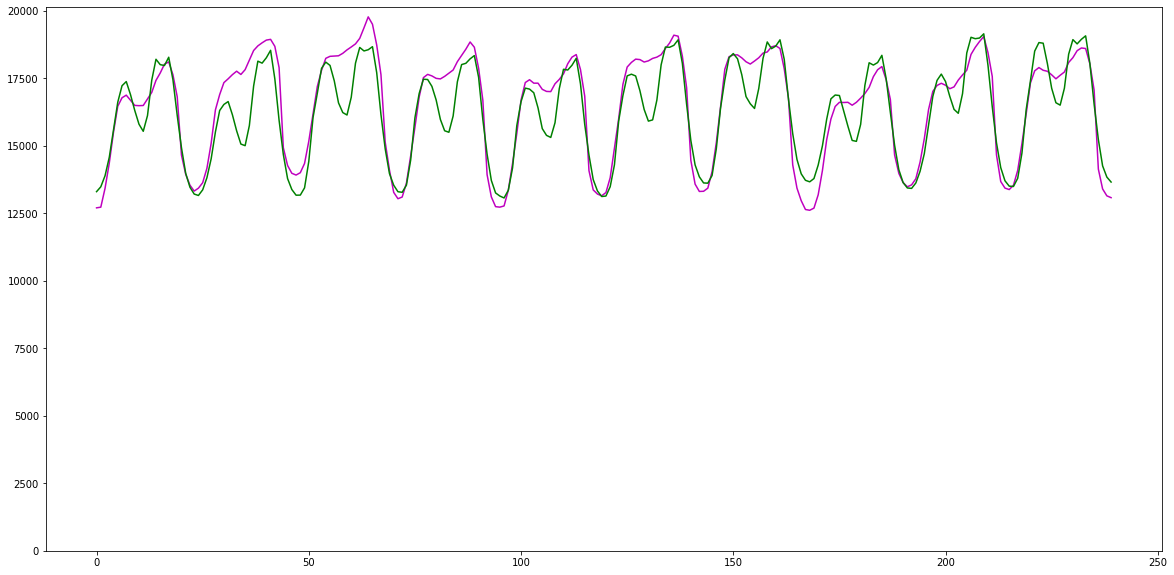

In [62]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, 24)
load_true = load_true.reshape(-1, 24)
plt.plot(load_pred[:240, 23], 'm')
plt.plot(load_true[:240, 23], 'g')
plt.ylim(ymin=0)